# Aridity 

### Description
Script calculates the Aridity Index (p/pet) for AGCD, ERA5, ERA5-land and downscaled CMIP6 models. Values for classification according to https://wad.jrc.ec.europa.eu/patternsaridity#:~:text=The%20Aridity%20Index%20(AI)%20is,climate%20at%20a%20given%20location.
Other reference: https://www.painblogr.org/2020-12-15-climate-change.html 

In [3]:
#< import modules
import os
import xarray as xr
import numpy as np
# import cmdline_provenance as cmdprov
# import git
import sys
import dask.distributed
import glob
from dask.distributed import Client
import tempfile
import dask
from dask.diagnostics import ProgressBar
import lib_david
import pickle

import warnings

# Ignore specific warning by category
warnings.filterwarnings('ignore') 

In [5]:
# Dask settings
dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, # This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #< This should use the new behaviour which helps with memory pile up
})

enc = {"AI": {
        "zlib": True,
        "complevel": 1,
        "shuffle": True
        }
      }

client = Client(n_workers=8, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38427/status,
Dashboard: /proxy/38427/status,Workers: 8
Total threads: 8,Total memory: 469.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37909,Workers: 8
Dashboard: /proxy/38427/status,Total threads: 8
Started: Just now,Total memory: 469.39 GiB
Comm: tcp://127.0.0.1:35563,Total threads: 1
Dashboard: /proxy/39257/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:33569,


In [3]:
# client.close()

In [6]:
def calc_AI(pr_file,e0_file,syear,eyear):
    # Open data since it's a single file and resample annually
    da_e0_raw = xr.open_mfdataset(infile_e0)['e0']
    da_e0 = da_e0_raw.resample(time='YE').sum('time')
    da_pr_raw = xr.open_mfdataset(infile_pr)['pr']
    da_pr = (da_pr_raw*86400).resample(time='YE').sum('time')

    # Select GWL periods
    e0 = da_e0.sel(time=slice(syear,eyear)).chunk({'time':-1,'lat':'auto','lon':'auto'})
    pr = da_pr.sel(time=slice(syear,eyear)).chunk({'time':-1,'lat':'auto','lon':'auto'})

    #Compute AI
    computed_AI = (pr/e0).astype("float32").rename("AI")
    return computed_AI

## For AWAP and AWRA-L

In [1]:
#< compute monthly sum from AWRA-L e0 daily files on /g/data/fj8/public/BoM/AWRA/Outputs/DailyScheduledRun/ using a bash script. Skips years that already exist.
!/home/565/dh4185/mn51-dh4185/resample_daily_AWRA-L_e0_to_monthly.sh

In [ ]:
#< For AWAP and AWRA-L -> they have different resolutions which I'm trying to sort out
path_awap_pr = "/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_*.nc"
path_awra_e0 = "/scratch/mn51/dh4185/e0_avg_*_monsum.nc"

file_name_ann_gwl = "/scratch/mn51/dh4185/AI-atmospheric-based_obs-AUS-5_AWAPv2-0-1-AWRAv7_na_na_obs_annual_historical.nc"

ds_awap_pr = xr.open_mfdataset(path_awap_pr, combine='nested').sel(time=slice('1950','2017'))
ds_awra_e0 = xr.open_mfdataset(path_awra_e0, combine='nested').sel(time=slice('1950','2017'))
print(ds_awap_pr)
print(ds_awra_e0)

## For NHP1.0 (CMIP5)

In [7]:
# Specify the path to your .pkl file
file_path = '/g/data/mn51/users/dh4185/hazards-drought/gwl_years.pkl'

# Open the file in binary read mode
with open(file_path, 'rb') as file:
    # Load the data from the file
    models_gwl = pickle.load(file)

print(models_gwl)
#< need to add 10 years to GWLs to calculate AI over 30 years?

path_templ_e0 = "/g/data/wj02/COMPLIANT_PUBLISHED/HMOUTPUT/output/AUS-5/BoM/"#{}/{}/{}/{}/latest/day/e0/"
path_templ_pr = "/g/data/wj02/COMPLIANT_PUBLISHED/HMINPUT/output/AUS-5/BoM/"#{}/{}/{}/{}/latest/day/pr/"

# files_e0 = lib_david.get_file_paths(path_templ_e0,".nc",include=["rcp45","e0"]) + lib_david.get_file_paths(path_templ_e0,".nc",include=["rcp85","e0"])
# files_pr = lib_david.get_file_paths(path_templ_pr,".nc",include=["rcp45","pr"],exclude=["BEFORE"]) + lib_david.get_file_paths(path_templ_pr,".nc",include=["rcp85","pr"],exclude=["BEFORE"])

bc_method = ["r240x120-QME","CSIRO-CCAM-r3355-r240x120-ISIMIP2b","_r240x120-ISIMIP2b","r240x120-MRNBC"]
index = "atmospheric-based"
var_e = "e0"

{'ACCESS1-0': {'rcp45': {'1.2': [2008, 2027], '1.5': [2022, 2041], '2': [2042, 2061]}, 'rcp85': {'1.2': [2010, 2029], '1.5': [2018, 2037], '2': [2031, 2050], '3': [2051, 2070], '4': [2071, 2090]}}, 'GFDL-ESM2M': {'rcp45': {'1.2': [2014, 2033], '1.5': [2037, 2056]}, 'rcp85': {'1.2': [2015, 2034], '1.5': [2027, 2046], '2': [2042, 2061], '3': [2073, 2092]}}, 'MIROC5': {'rcp45': {'1.2': [2019, 2038], '1.5': [2030, 2049], '2': [2063, 2082]}, 'rcp85': {'1.2': [2014, 2033], '1.5': [2024, 2043], '2': [2039, 2058], '3': [2063, 2082]}}, 'CNRM-CM5': {'rcp45': {'1.2': [2015, 2034], '1.5': [2028, 2047], '2': [2049, 2068]}, 'rcp85': {'1.2': [2011, 2030], '1.5': [2021, 2040], '2': [2036, 2055], '3': [2058, 2077], '4': [2078, 2097]}}}


In [9]:
for model in models_gwl:
    print('========= '+model+' =========')
    
    for rcp in models_gwl[model]:
        print(rcp)

        for bc in bc_method:
            infile_e0 = lib_david.get_file_paths(path_templ_e0,".nc",include=[rcp,model,bc,"e0"])
            infile_pr = lib_david.get_file_paths(path_templ_pr,".nc",include=[rcp,model,bc,"pr"],exclude=["BEFORE"])
            run = infile_e0[0].split('/')[11]

            file_name_ann = "/g/data/ia39/ncra/drought_aridity/ai/AI-{}_NHP1-AUS-5_{}_{}_{}_{}_{}_{}.nc".format(index,model,rcp,run,bc,'annual','2006-2099')
                
            if os.path.exists(file_name_ann)==False:
                computed_AI_ann = calc_AI(infile_pr,infile_e0,'2006','2099')
                print("Computing {name}...".format(name=file_name_ann))
                computed_AI_ann.attrs['description'] = f'Ratio of precipitation to (potential)evepotranspiration produced from National Hydrological Projections (NHP1.0) on /g/data/wj02/COMPLIANT_PUBLISHED/. Produced for ACS. '
                computed_AI_ann.attrs['method']  = 'Using  {} aridity: pr/{}'.format(index,var_e)
                # computed_AI_ann.attrs['history'] = cmdprov.new_log(extra_notes=[get_git_hash()])
                computed_AI_ann.attrs['comment'] = "Using data on /g/data/wj02/COMPLIANT_PUBLISHED/" ;
                computed_AI_ann.attrs['cell_methods'] = "time: mean" ;
                computed_AI_ann.attrs['bias correction'] = "method: {}".format(bc) ;
                
                #< Save output
                saver_ann = computed_AI_ann.to_netcdf(file_name_ann,compute=False)
                future_ann = client.persist(saver_ann)
                dask.distributed.progress(future_ann)
                future_ann.compute()
            else:
                print("{name} exists. Pass.".format(name=file_name_ann))
                
            
            for gwl in models_gwl[model][rcp]:
                print(gwl)
                
                syear = str(models_gwl[model][rcp][gwl][0])
                eyear = str(models_gwl[model][rcp][gwl][1])
                run = infile_e0[0].split('/')[11]

                ###############################  Truncate to annual GWL time series IF previous file exists ############################################
                file_name_ann_gwl = "/g/data/ia39/ncra/drought_aridity/ai/AI-{}_NHP1-AUS-5_{}_{}_{}_{}_{}_{}.nc".format(index,model,rcp,run,bc,'annual','GWL'+str(int(float(gwl)*10))) 

                if os.path.exists(file_name_ann_gwl)==False:

                    ds_AI_ann_gwl = xr.open_dataset(file_name_ann).sel(time=slice(syear,eyear))

                    ds_AI_ann_gwl.attrs['description'] = f'Ratio of precipitation to (potential)evepotranspiration produced from National Hydrological Projections (NHP1.0) on /g/data/wj02/COMPLIANT_PUBLISHED/. Produced for ACS. '
                    ds_AI_ann_gwl.attrs['method']  = 'Using  {} aridity: pr/{}'.format(index,var_e)
                    # ds_AI_ann_gwl.attrs['history'] = cmdprov.new_log(extra_notes=[get_git_hash()])
                    ds_AI_ann_gwl.attrs['comment'] = "Using data on /g/data/wj02/COMPLIANT_PUBLISHED/" ;
                    ds_AI_ann_gwl.attrs['cell_methods'] = "time: mean" ;
                    print("Computing {name}...".format(name=file_name_ann_gwl))

                    #< Save output
                    ds_AI_ann_gwl.to_netcdf(file_name_ann_gwl)

                else:
                    print("{name} exists. Pass.".format(name=file_name_ann_gwl))

                    
                ###############################  Create 2D GWL IF time series file exists ############################################
                file_name_2D_gwl = "/g/data/ia39/ncra/drought_aridity/ai/AI-{}_NHP1-AUS-5_{}_{}_{}_{}_{}_{}.nc".format(index,model,rcp,run,bc,'2D','GWL'+str(int(float(gwl)*10)))

                if os.path.exists(file_name_2D_gwl)==False:
                            
                    ds_AI_2D_gwl = xr.open_dataset(file_name_ann).sel(time=slice(syear,eyear)).mean('time')

                    ds_AI_2D_gwl.attrs['description'] = f'Ratio of precipitation to (potential)evepotranspiration produced from National Hydrological Projections (NHP1.0) on /g/data/wj02/COMPLIANT_PUBLISHED/. Produced for ACS. '
                    ds_AI_2D_gwl.attrs['method']  = 'Using  {} aridity: pr/{}'.format(index,var_e)
                    # ds_AI_2D_gwl.attrs['history'] = cmdprov.new_log(extra_notes=[get_git_hash()])
                    ds_AI_2D_gwl.attrs['comment'] = "Using data on /g/data/wj02/COMPLIANT_PUBLISHED/" ;
                    ds_AI_2D_gwl.attrs['cell_methods'] = "time: mean" ;
                    print("Computing {name}...".format(name=file_name_2D_gwl))

                    #< Save output
                    ds_AI_2D_gwl.to_netcdf(file_name_2D_gwl)
                else:
                    print("{name} exists. Pass.".format(name=file_name_2D_gwl))


                
                # # Store the computed AI data array in the dictionary
                # extended_dataarray.loc[dict(GWL=gwl, BC=bc, model=model, rcp=rcp)] = computed_AI
                  

#< Looking at files to check
# for item in path_e0:
#     print(item.split("/")[-1])

========= ACCESS1-0 =========
rcp45
/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp45_r1i1p1_r240x120-QME_annual_2006-2099.nc exists. Pass.
1.2
Computing /g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp45_r1i1p1_r240x120-QME_annual_GWL12.nc...
Computing /g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp45_r1i1p1_r240x120-QME_2D_GWL12.nc...
1.5
Computing /g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp45_r1i1p1_r240x120-QME_annual_GWL15.nc...
Computing /g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp45_r1i1p1_r240x120-QME_2D_GWL15.nc...
2
Computing /g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp45_r1i1p1_r240x120-QME_annual_GWL20.nc...
Computing /g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp45_r1i1p1_r240x120-QME_2D_GWL20.nc...
/g/data/ia39/ncra/droug

## Testing

/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp85_r1i1p1_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_2D_GWL20.nc
/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_CNRM-CM5_rcp85_r1i1p1__r240x120-ISIMIP2b_2D_GWL20.nc
/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_CNRM-CM5_rcp85_r1i1p1_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_2D_GWL20.nc
/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_MIROC5_rcp85_r1i1p1_r240x120-MRNBC_2D_GWL20.nc
/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_CNRM-CM5_rcp85_r1i1p1_r240x120-QME_2D_GWL20.nc
/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_MIROC5_rcp85_r1i1p1_CSIRO-CCAM-r3355-r240x120-ISIMIP2b_2D_GWL20.nc
/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp85_r1i1p1__r240x120-ISIMIP2b_2D_GWL20.nc
/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_GFDL-ESM2M_rcp85_r1i1p1__r240x120-ISIMIP2

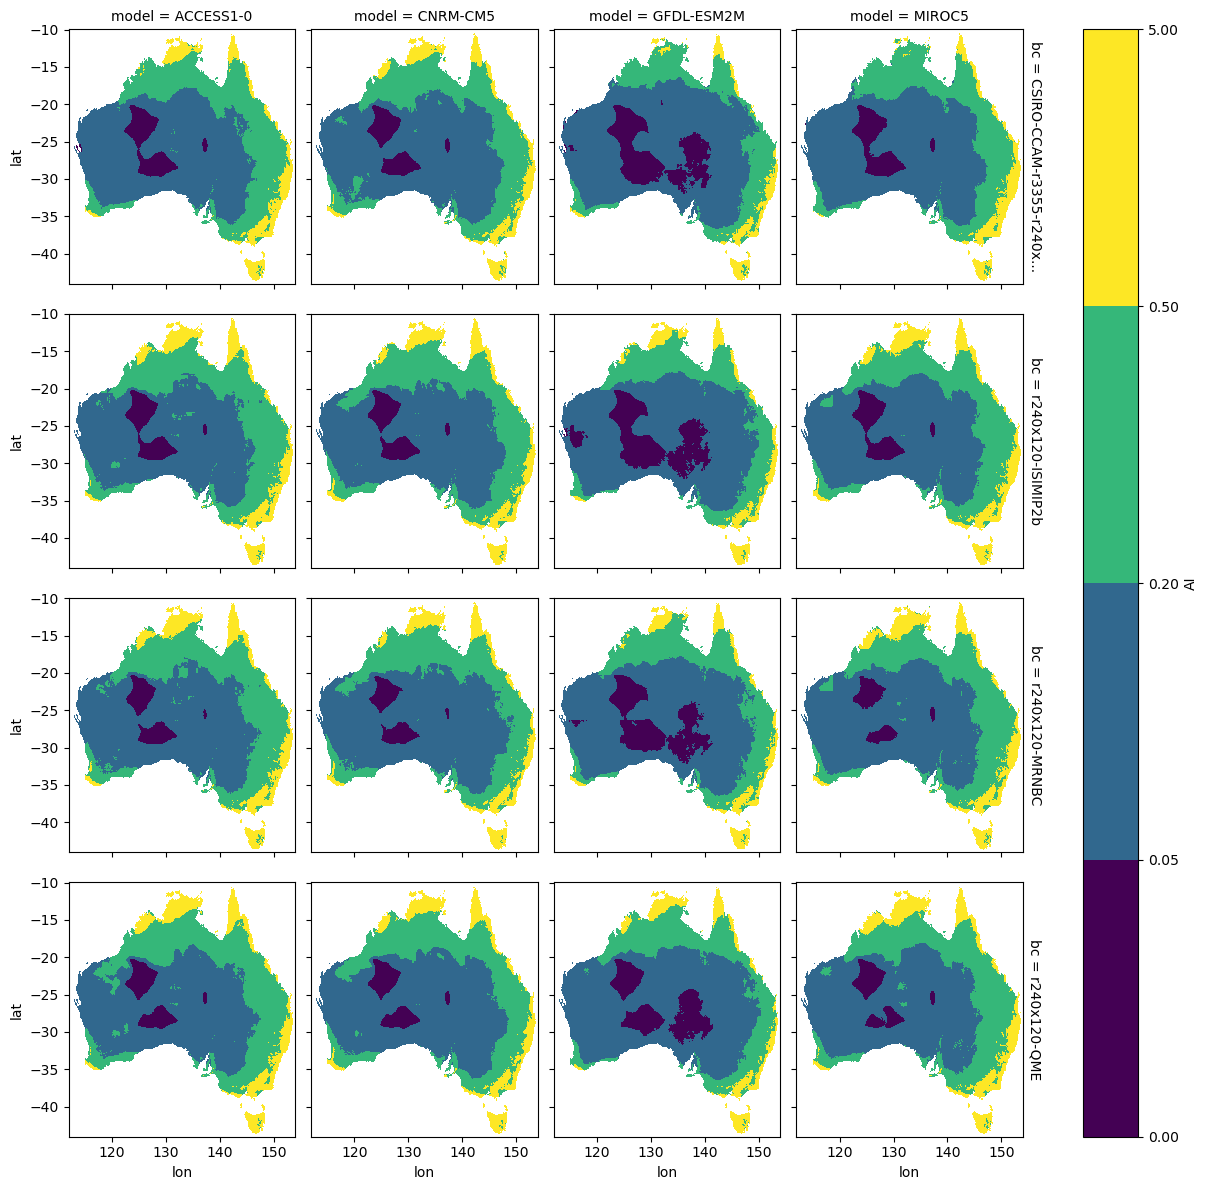

In [16]:
root_dir = "/g/data/ia39/ncra/drought_aridity/ai/"
files = lib_david.get_file_paths(root_dir,".nc",include=["AI-atmospheric","rcp85","GWL20","2D"],exclude=["BEFORE"])
for file in files:
    print(file)
da_list = []
for file in files:
    model = file.split('_')[3]
    bc = file.split('_')[-3]
    rcp = file.split('_')[4]
    gwl = file.split('_')[-1][:-3]

    print('Model: '+model, 'BC: '+bc, 'RCP: '+rcp, 'GWL: '+gwl)
    
    da = xr.open_dataset(file)['AI']
    da = da.expand_dims(dim={"model": [model],"bc": [bc],"rcp": [rcp],"gwl": [gwl]}, axis=[0,1,2,3])
    da_list.append(da)

da_all = xr.merge(da_list)
print(da_all)
da_all.AI.plot(row='bc',col='model',levels=[0,0.05,0.2,0.5,5])#, "bc": bc, "rcp": rcp, "GWL": gwl})

# FOR CMIP6 - set parameters 

In [ ]:
# #< FOR CMIP6 - set parameters 

# out_dir  = "/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/"

# # GWL2 from https://github.com/IPCC-WG1/Atlas/blob/main/warming-levels/CMIP6_Atlas_WarmingLevels.csv
# # and Mitch's email.

# climatology = {'recent':{'start':1991,'end':2020},
#                'current':{'start':2011,'end':2030},
#                # 'GWL2-ssp126':{
#                #     # 'CMCC-ESM2':{'start':-9,'end':+10}, # can't find it in table
#                #     'ACCESS-ESM1-5':{'start':2072-9,'end':2072+10},
#                #     'ACCESS-CM2':{'start':2042-9,'end':2042+10},
#                #     'EC-Earth3':{'start':2043-9,'end':2043+10},
#                #     # 'MPI-ESM1-2-HR':{'start':2050-9,'end':2050+10},
#                #     # 'NCAR-CESM2':{'start':-9,'end':+10}, can't find it in table
#                #     'NorESM2-MM':{'start':None,'end':None}},
#                'GWL2-ssp370':{
#                    'CMCC-ESM2':{'start':2041-9,'end':2041+10},
#                    'ACCESS-ESM1-5':{'start':2048-9,'end':2048+10},
#                    'ACCESS-CM2':{'start':2039-9,'end':2039+10},
#                    'EC-Earth3':{'start':2038-9,'end':2038+10},
#                    'MPI-ESM1-2-HR':{'start':2050-9,'end':2050+10},
#                    'NCAR-CESM2':{'start':2043-9,'end':2043+10},
#                    'NorESM2-MM':{'start':2062-9,'end':2062+10}}
#               }

# source_char = {
#     'ERA5':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[]},
#     'AGCD':{'var_p':'precip','var_pet':'e0','var_lat':'latitude','var_lon':'longitude','files':[]},
#     'CMIP6':{
#         'CMCC-ESM2':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'CMCC-ESM2','variant-id':'r1i1p1f1','version':'v1-r1'}, 
#         'ACCESS-ESM1-5':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'ACCESS-ESM1-5','variant-id':'r6i1p1f1','version':'v1-r1'},
#         'ACCESS-CM2':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'ACCESS-CM2','variant-id':'r4i1p1f1','version':'v1-r1'},
#         'EC-Earth3':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'EC-Earth3','variant-id':'r1i1p1f1','version':'v1-r1'},
#         'MPI-ESM1-2-HR':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'MPI-ESM1-2-HR','variant-id':'r1i1p1f1','version':'v1-r1'}, # only historical},
#         'NCAR-CESM2':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'CESM2','variant-id':'r11i1p1f1','version':'v1-r1'}, 
#         'NorESM2-MM':{'var_p':'pr','var_pet':'evspsblpot','var_lat':'lat','var_lon':'lon','files':[],'name':'NorESM2-MM','variant-id':'r1i1p1f1','version':'v1-r1'}
#         }
#     }